In [2]:
import sqlite3
import pandas
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

conn = sqlite3.connect('db.sqlite3')
data = conn.execute("""
with data_time as (
select sum(value) as attendances, commune_id, date(data.year || '-' || (
    case data.cohort
        when 'Enero' then '01'
        when 'Febrero' then '02'
        when 'Marzo' then '03'
        when 'Abril' then '04'
        when 'Mayo' then '05'
        when 'Junio' then '06'
        when 'Julio' then '07'
        when 'Agosto' then '08'
        when 'Septiembre' then '09'
        when 'Octubre' then '10'
        when 'Noviembre' then '11'
        when 'Diciembre' then '12'
        else 1
    end) || '-01') as date
from data
join report on data.report_id = report.id
where report.description = 'Ingresos Programa de Salud Mental por mes y año'
group by date, commune_id
),
contaminant_time as (
select avg(concentration) as concentration, commune_id, date(datetime, 'unixepoch', 'start of month') as date
from contaminant
where contaminant.contaminant = 'SO2'
group by date, commune_id
)
select commune.name, contaminant_time.concentration, data_time.date, attendances * 10000 / commune.population from data_time
join contaminant_time on data_time.date = contaminant_time.date and data_time.commune_id = contaminant_time.commune_id
join commune on data_time.commune_id = commune.id
""").fetchall()

# drop unixtimestamp
data = pandas.DataFrame(data, columns=['commune', 'concentration', 'date', 'attendances'])
data.index = pandas.to_datetime(data['date'])
data = data.drop(columns=['date'])

# scale
scaler = StandardScaler()
data[['concentration']] = scaler.fit_transform(data[['concentration']])
data[['attendances']] = scaler.fit_transform(data[['attendances']])

data

,commune,concentration,attendances
date,,,
2018-01-01,LA CISTERNA,0.318082,0.301024
2018-01-01,PENALOLEN,-1.227433,0.614815
2018-01-01,PUENTE ALTO,0.839011,0.824010
2018-01-01,TALAGANTE,-1.602993,-0.849545
2018-02-01,LA CISTERNA,-1.384115,-0.640351
...,...,...,...
2024-04-01,LA CISTERNA,1.280945,1.137801
2024-04-01,PENALOLEN,0.998143,0.510218
2024-05-01,PENALOLEN,1.432024,0.614815


rmse for LA CISTERNA: 0.43185050497440053


/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWa

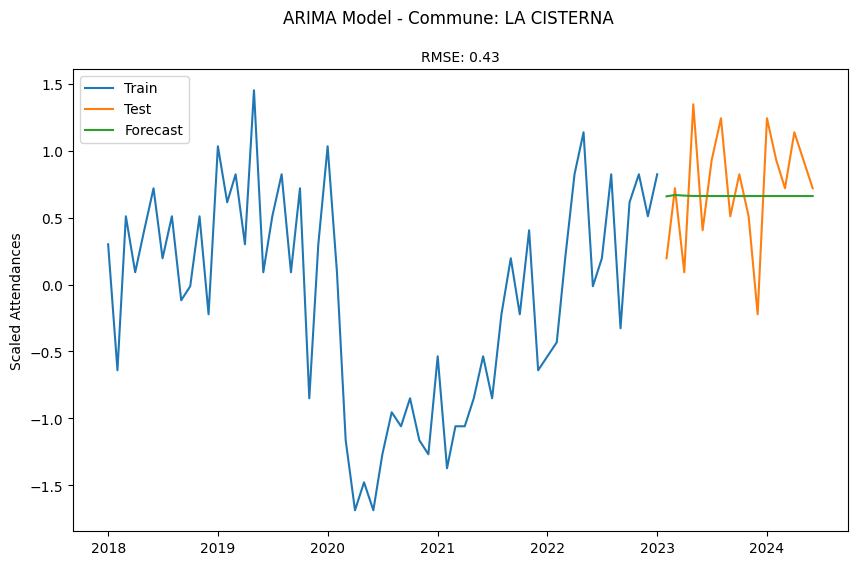

/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWa

rmse for LA CISTERNA with so2: 0.43203172664162953


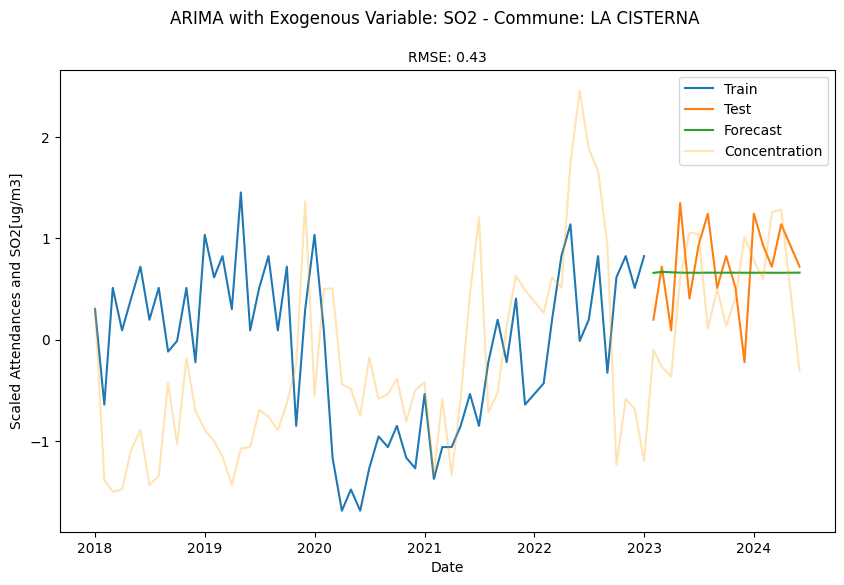

/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWa

rmse for PENALOLEN: 0.8858089893147755


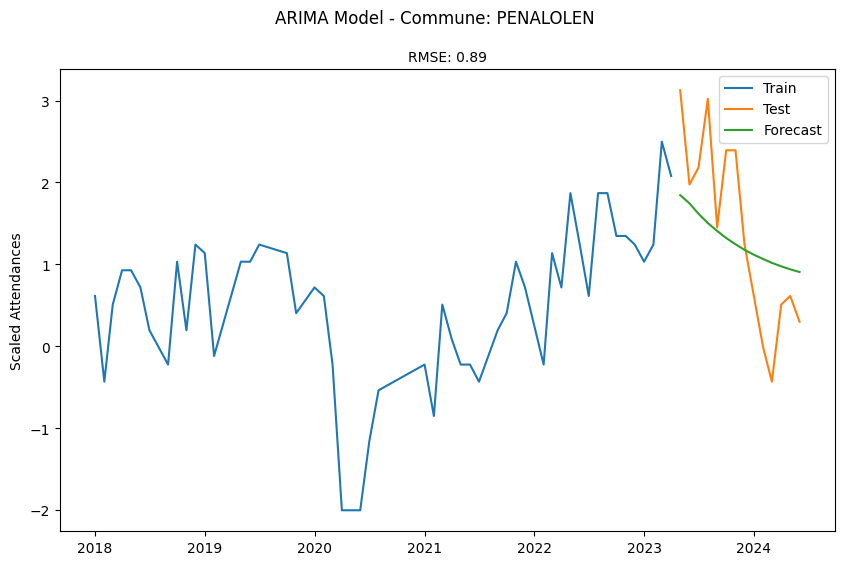

/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWa

rmse for PENALOLEN with so2: 0.8931239007765663


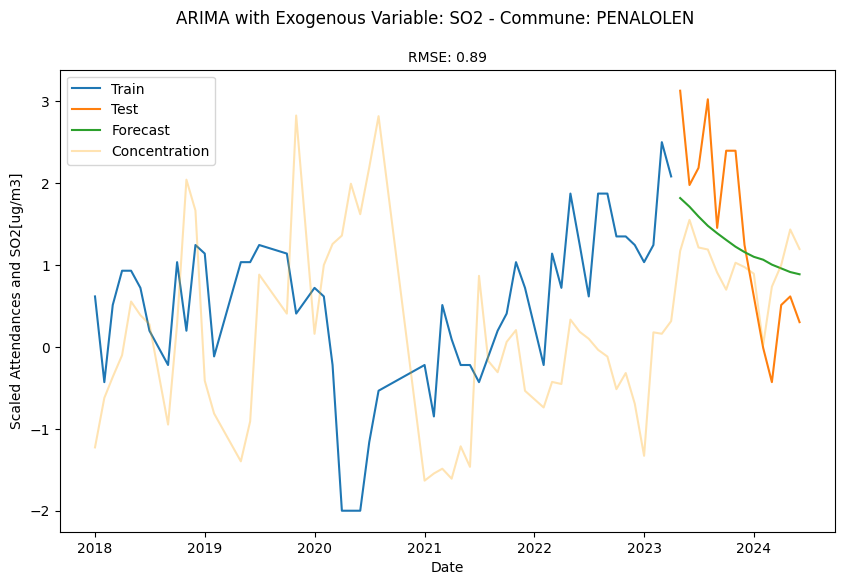

/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWa

rmse for PUENTE ALTO: 0.40531647095281137


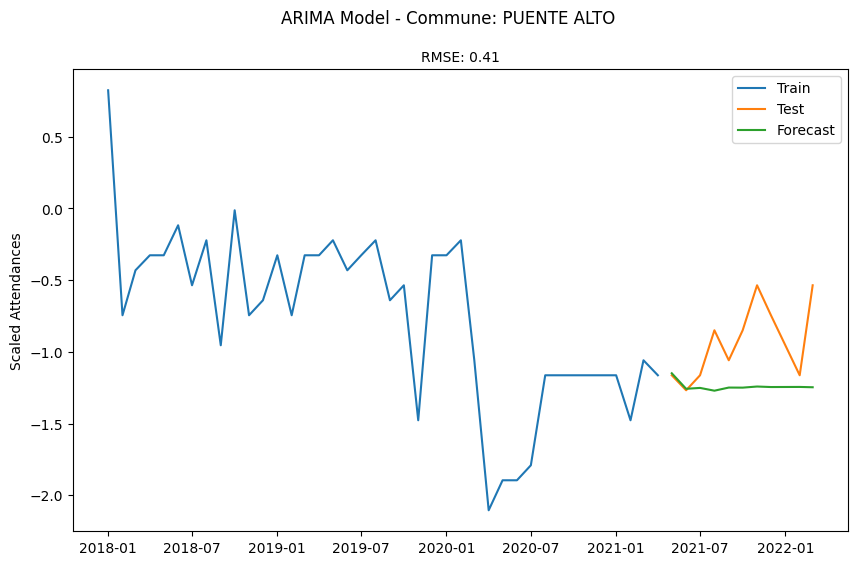

/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWa

rmse for PUENTE ALTO with so2: 0.3998418235868894


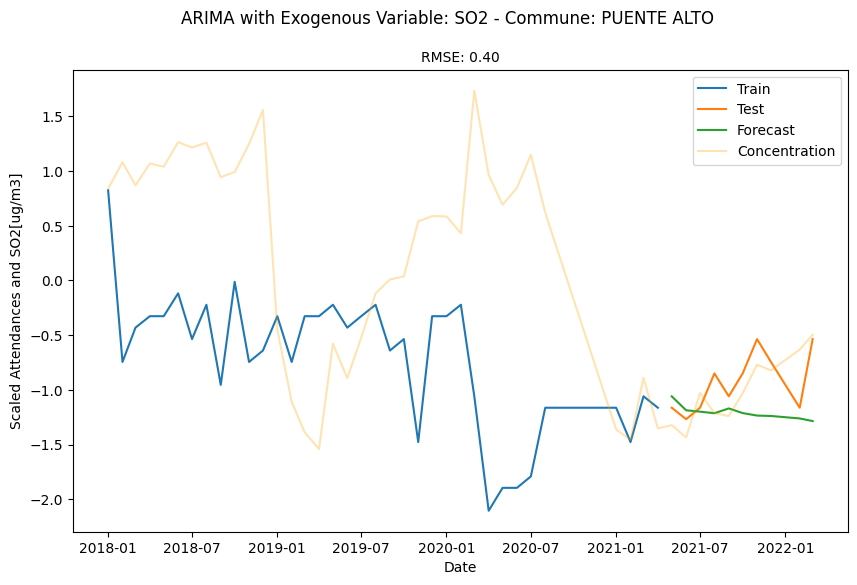

/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


rmse for TALAGANTE: 1.062332461194623


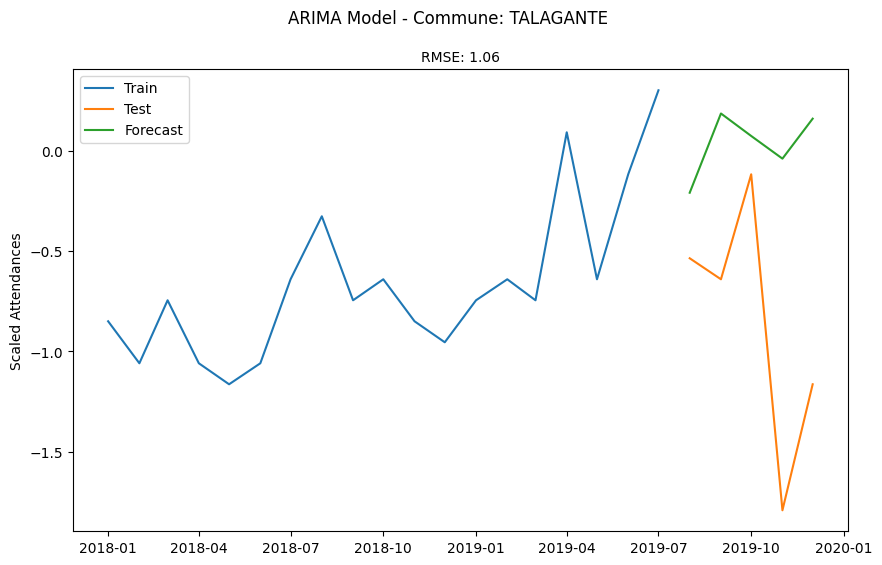

/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


rmse for TALAGANTE with so2: 0.9232289920856458


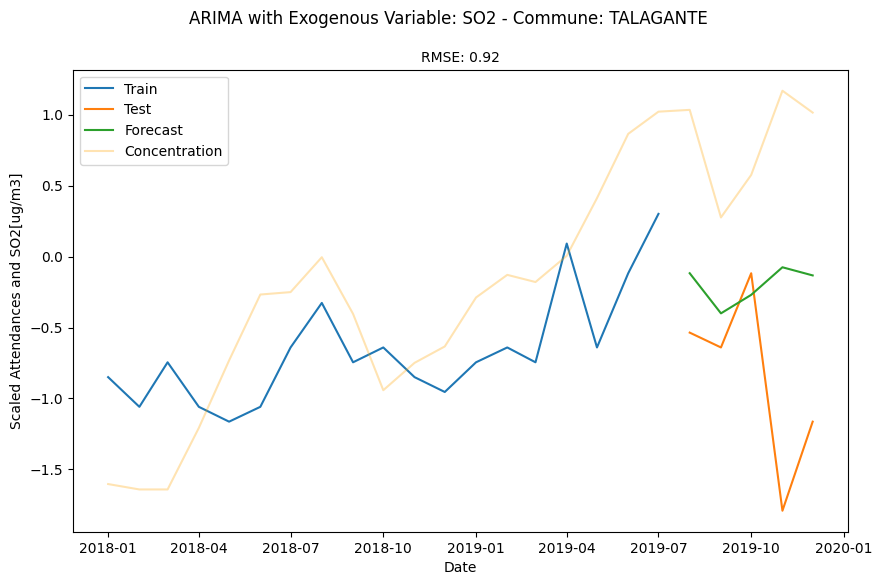

In [3]:
# loop over communes
for commune in data['commune'].unique():
    A = data[data['commune'] == commune]

    A_train, A_test = train_test_split(A, test_size=0.2, shuffle=False)

    # evaluate
    model = ARIMA(A_train['attendances'], order=(3,1,1))
    model_fit = model.fit()
    rmse = root_mean_squared_error(A_test['attendances'], model_fit.forecast(steps=len(A_test)))
    print(f'rmse for {commune}: {rmse}')
    # print(model_fit.summary())

    # plot
    plt.figure(figsize=(10,6))
    plt.suptitle('ARIMA Model - Commune: ' + commune)
    plt.title(f'RMSE: {rmse:<.2f}', fontsize=10)
    plt.ylabel('Scaled Attendances')
    plt.plot(A_train.index, A_train['attendances'], label='Train')
    plt.plot(A_test.index, A_test['attendances'], label='Test')
    plt.plot(A_test.index, model_fit.forecast(steps=len(A_test)), label='Forecast')
    plt.legend()
    plt.savefig(f'img/arima_{commune}.png')
    plt.show()

    # multi-feature ARIMA per commune
    model = ARIMA(A_train['attendances'], exog=A_train[['concentration']], order=(3,1,1))
    model_fit = model.fit()

    # evaluate
    rmse = root_mean_squared_error(A_test['attendances'], model_fit.forecast(steps=len(A_test), exog=A_test[['concentration']]))
    print(f'rmse for {commune} with so2: {rmse}')
    # print(model_fit.summary())

    # plot
    plt.figure(figsize=(10,6))
    plt.suptitle('ARIMA with Exogenous Variable: SO2 - Commune: ' + commune)
    plt.title(f'RMSE: {rmse:<.2f}', fontsize=10)
    plt.xlabel('Date')
    plt.ylabel('Scaled Attendances and SO2[ug/m3]')
    plt.plot(A_train.index, A_train['attendances'], label='Train')
    plt.plot(A_test.index, A_test['attendances'], label='Test')
    # plot train forecast
    plt.plot(A_test.index, model_fit.forecast(steps=len(A_test), exog=A_test[['concentration']]), label='Forecast')
    # plot concentration
    plt.plot(A.index, A['concentration'], label='Concentration', color='orange', alpha=0.3)
    plt.legend()
    plt.savefig(f'img/arima_{commune}_so2.png')
    plt.show()
